In [1]:
import pandas as pd
import cudf as gd
import dask.dataframe as dd
import dask
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
import dask_cudf
import matplotlib.pyplot as plt

import os
from glob import glob
from tqdm import tqdm
import cudf as gd
import seaborn 
seaborn.set_theme()

os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
IP = '10.2.54.138'
gd.__version__

'0.15.0'

### List csv files

In [2]:
path = '/raid/data/dream/single_cell_breast_cancer/single_cell_phospo/complete_cell_lines/*.csv'
files = glob(path)
print(f"number of files: {len(files)}")
print("first 5 files")
files[:5]

number of files: 44
first 5 files


['/raid/data/dream/single_cell_breast_cancer/single_cell_phospo/complete_cell_lines/T47D.csv',
 '/raid/data/dream/single_cell_breast_cancer/single_cell_phospo/complete_cell_lines/HCC1187.csv',
 '/raid/data/dream/single_cell_breast_cancer/single_cell_phospo/complete_cell_lines/184A1.csv',
 '/raid/data/dream/single_cell_breast_cancer/single_cell_phospo/complete_cell_lines/HCC70.csv',
 '/raid/data/dream/single_cell_breast_cancer/single_cell_phospo/complete_cell_lines/HCC1569.csv']

#### specify column datatypes

In [3]:
%%time
cols = ['treatment', 'cell_line', 'time', 'cellID', 'fileID', 'b.CATENIN',
       'cleavedCas', 'CyclinB', 'GAPDH', 'IdU', 'Ki.67', 'p.4EBP1',
       'p.Akt.Ser473.', 'p.AKT.Thr308.', 'p.AMPK', 'p.BTK', 'p.CREB', 'p.ERK',
       'p.FAK', 'p.GSK3b', 'p.H3', 'p.HER2', 'p.JNK', 'p.MAP2K3', 'p.MAPKAPK2',
       'p.MEK', 'p.MKK3.MKK6', 'p.MKK4', 'p.NFkB', 'p.p38', 'p.p53',
       'p.p90RSK', 'p.PDPK1', 'p.PLCg2', 'p.RB', 'p.S6', 'p.S6K', 'p.SMAD23',
       'p.SRC', 'p.STAT1', 'p.STAT3', 'p.STAT5']

cat_cols = ['treatment','cell_line']
int_cols = ['cellID','fileID']

dtype = {col:'float32' for col in cols}
for col in cat_cols:
    dtype[col] = 'str'
for col in int_cols:
    dtype[col] = 'int32'

CPU times: user 5 µs, sys: 6 µs, total: 11 µs
Wall time: 13.1 µs


### Processing using a single CPU pandas

In [4]:
%%time

dfs = []
for name in tqdm(files, total=len(files)):
    df = pd.read_csv(name, dtype=dtype)
    dfs.append(df)
df = pd.concat(dfs).reset_index(drop=True)
print(f"number of samples: {len(df)} number of features: {df.shape[1]}")
df.head()

100%|██████████| 44/44 [00:57<00:00,  1.30s/it]


number of samples: 17126329 number of features: 42
CPU times: user 56.6 s, sys: 3.38 s, total: 60 s
Wall time: 59.9 s


,treatment,cell_line,time,cellID,fileID,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,...,p.PDPK1,p.PLCg2,p.RB,p.S6,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
0,EGF,T47D,0.0,1,4409,0.796624,0.306229,1.297073,0.891318,5.71236,...,0.772370,2.743286,1.65488,4.20608,-0.001418,-0.015309,1.16876,1.598715,0.837434,0.816828
1,EGF,T47D,0.0,1,4448,0.796624,3.109714,2.220135,2.705554,5.45159,...,1.956205,3.036988,3.00336,4.23727,1.740510,2.353130,3.01003,3.248560,2.083733,2.338155
2,EGF,T47D,0.0,2,4409,2.333222,0.666159,2.071017,3.457015,4.36651,...,2.130890,2.666452,2.92672,3.54356,1.884160,1.601490,2.46310,2.570571,2.637739,1.765523
3,EGF,T47D,0.0,2,4448,0.796624,2.440076,1.784047,3.291843,4.91425,...,2.728141,2.882141,2.45918,3.93215,1.404670,2.079070,3.32673,3.688558,0.323054,1.216045
4,EGF,T47D,0.0,3,4409,2.835704,2.166169,2.652001,4.160961,4.36651,...,2.725089,3.195160,3.05361,4.74688,1.822100,1.609680,2.60451,3.153991,0.323054,2.383754


In [5]:
%%time

markers = df.columns.values.tolist()[5:]
agg = df.groupby(['treatment', 'cell_line', 'time']).agg({col:'mean' for col in markers})
agg.head()

CPU times: user 5.18 s, sys: 893 ms, total: 6.08 s
Wall time: 6.07 s


b.CATENIN  cleavedCas   CyclinB     GAPDH       IdU  \
treatment cell_line time                                                        
EGF       184A1     0.0    1.196279    2.435572  1.900403  2.654693  5.151532   
                    5.5    1.061006    2.397379  2.002467  2.962796  5.132364   
                    7.0    1.066766    2.453995  1.799739  2.950558  5.155396   
                    9.0    1.247629    2.693877  2.021418  3.234935  5.087694   
                    13.0   1.153863    2.487997  2.011611  2.987483  5.080868   

                             Ki.67   p.4EBP1  p.Akt.Ser473.  p.AKT.Thr308.  \
treatment cell_line time                                                     
EGF       184A1     0.0   2.316098  2.136962       2.102930       2.301484   
                    5.5   2.724814  1.869129       2.570316       2.337482   
                    7.0   2.048535  1.910847       2.571702       2.357979   
                    9.0   2.528926  2.090955       2.623367       2.599768   
                    13.0  2.781838  1.845221       2.549117       2.372898   

                            p.AMPK  ...   p.PDPK1   p.PLCg2      p.RB  \
treatment cell_line time            ...                                 
EGF       184A1     0.0   3.058772  ...  2.250440  1.766767  4.593911   
                    5.5   3.414187  ...  2.433981  1.704150  4.199304   
                    7.0   3.488281  ...  2.435173  1.888861  4.129381   
                    9.0   3.696993  ...  2.704787  2.081891  4.399864   
                    13.0  3.621439  ...  2.488372  1.984926  4.249192   

                              p.S6     p.S6K  p.SMAD23     p.SRC   p.STAT1  \
treatment cell_line time                                                     
EGF       184A1     0.0   4.650949  1.927272  2.145606  1.938507  2.208739   
                    5.5   4.864960  2.272765  2.018080  1.693753  2.241844   
                    7.0   4.342659  2.176830  2.070670  1.750334  2.203354   
                    9.0   4.714650  2.394578  2.317751  1.843912  2.384290   
                    13.0  5.288835  2.365986  2.102938  1.790670  2.406991   

                           p.STAT3   p.STAT5  
treatment cell_line time                      
EGF       184A1     0.0   1.880624  1.670707  
                    5.5   1.882191  1.976372  
                    7.0   2.919065  2.379102  
                    9.0   2.868250  2.393214  
                    13.0  2.296516  2.373878  

[5 rows x 37 columns]

In [6]:
agg.columns = [f'{i}_mean' for i in markers]
agg = agg.reset_index()
agg = agg.sort_values(['treatment', 'cell_line', 'time'])

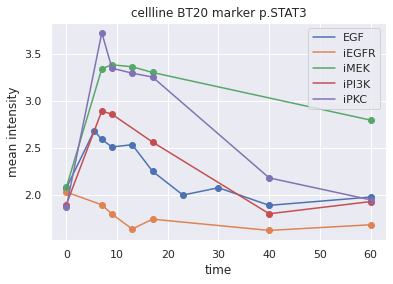

In [23]:
fig = plt.figure()
for t in agg['treatment'].unique():
    if t == 'full':
        continue
    mask = (agg['cell_line'] == 'BT20') & (agg['treatment'] == t)
    x = agg.loc[mask, 'time'].values
    y = agg.loc[mask, 'p.STAT3_mean'].values
    plt.plot(x,y,label=t)
    plt.scatter(x,y)
plt.xlabel('time')
plt.ylabel('mean intensity')
plt.title('cellline BT20 marker p.STAT3')
plt.legend()

In [24]:
plt.savefig('line_plot.pdf', dpi=1000)

<Figure size 432x288 with 0 Axes>

In [8]:
%%time

df = df.merge(agg, on=['treatment', 'cell_line', 'time'], how='left')

CPU times: user 5.86 s, sys: 1.2 s, total: 7.06 s
Wall time: 7.05 s


### Processing using a single GPU with cudf

In [9]:
%%time

dfs = []
for name in tqdm(files, total=len(files)):
    gdf = gd.read_csv(name, dtype=dtype)
    dfs.append(gdf)
gdf = gd.concat(dfs).reset_index(drop=True)
print(f"number of samples: {len(gdf)} number of features: {gdf.shape[1]}")
gdf.head()

100%|██████████| 44/44 [00:05<00:00,  8.16it/s]


number of samples: 17126329 number of features: 42
CPU times: user 3.9 s, sys: 1.75 s, total: 5.65 s
Wall time: 5.77 s


,treatment,cell_line,time,cellID,fileID,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,...,p.PDPK1,p.PLCg2,p.RB,p.S6,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
0,EGF,T47D,0.0,1,4409,0.796624,0.306229,1.297073,0.891318,5.712360,...,0.772370,2.743286,1.65488,4.20608,-0.001418,-0.015309,1.16876,1.598715,0.837434,0.816828
1,EGF,T47D,0.0,1,4448,0.796624,3.109714,2.220135,2.705554,5.451591,...,1.956205,3.036988,3.00336,4.23727,1.740510,2.353130,3.01003,3.248560,2.083733,2.338155
2,EGF,T47D,0.0,2,4409,2.333222,0.666159,2.071017,3.457015,4.366510,...,2.130890,2.666452,2.92672,3.54356,1.884160,1.601490,2.46310,2.570571,2.637739,1.765523
3,EGF,T47D,0.0,2,4448,0.796624,2.440076,1.784047,3.291843,4.914250,...,2.728141,2.882141,2.45918,3.93215,1.404670,2.079070,3.32673,3.688558,0.323054,1.216045
4,EGF,T47D,0.0,3,4409,2.835704,2.166169,2.652001,4.160961,4.366510,...,2.725089,3.195160,3.05361,4.74688,1.822100,1.609680,2.60451,3.153991,0.323054,2.383754


In [10]:
%%time

markers = gdf.columns.values.tolist()[5:]
gagg = gdf.groupby(['treatment', 'cell_line', 'time']).agg({col:'mean' for col in markers})
gagg.head()

CPU times: user 553 ms, sys: 420 ms, total: 974 ms
Wall time: 975 ms


b.CATENIN  cleavedCas   CyclinB     GAPDH       IdU  \
treatment cell_line time                                                        
EGF       184A1     0.0    1.196257    2.435584  1.900452  2.654714  5.151463   
                    5.5    1.060984    2.397385  2.002515  2.962810  5.132311   
                    7.0    1.066744    2.454003  1.799790  2.950561  5.155364   
                    9.0    1.247607    2.693882  2.021283  3.234933  5.087629   
                    13.0   1.153839    2.488003  2.011662  2.987493  5.080800   

                             Ki.67   p.4EBP1  p.Akt.Ser473.  p.AKT.Thr308.  \
treatment cell_line time                                                     
EGF       184A1     0.0   2.316226  2.136826       2.102934       2.301452   
                    5.5   2.724927  1.869045       2.570316       2.337467   
                    7.0   2.048663  1.910770       2.571702       2.357963   
                    9.0   2.528861  2.090779       2.623374       2.599736   
                    13.0  2.781874  1.845071       2.549117       2.372867   

                            p.AMPK  ...   p.PDPK1   p.PLCg2      p.RB  \
treatment cell_line time            ...                                 
EGF       184A1     0.0   3.058766  ...  2.250414  1.766799  4.593887   
                    5.5   3.414182  ...  2.433965  1.704178  4.199254   
                    7.0   3.488281  ...  2.435169  1.888886  4.129332   
                    9.0   3.696978  ...  2.704782  2.081796  4.399903   
                    13.0  3.621435  ...  2.488357  1.984947  4.249137   

                              p.S6     p.S6K  p.SMAD23     p.SRC   p.STAT1  \
treatment cell_line time                                                     
EGF       184A1     0.0   4.650901  1.927302  2.145581  1.938525  2.208733   
                    5.5   4.864927  2.272775  2.018071  1.693750  2.241843   
                    7.0   4.342625  2.176836  2.070663  1.750332  2.203355   
                    9.0   4.714676  2.394587  2.317719  1.843937  2.384288   
                    13.0  5.288821  2.365992  2.102918  1.790687  2.406993   

                           p.STAT3   p.STAT5  
treatment cell_line time                      
EGF       184A1     0.0   1.880610  1.670708  
                    5.5   1.882181  1.976373  
                    7.0   2.919060  2.379094  
                    9.0   2.868247  2.393221  
                    13.0  2.296504  2.373871  

[5 rows x 37 columns]

In [11]:
gagg.columns = [f'{i}_mean' for i in markers]
gagg = gagg.reset_index()
gagg = gagg.sort_values(['treatment', 'cell_line', 'time'])

In [12]:
%%time

gdf = gdf.merge(gagg, on=['treatment', 'cell_line', 'time'], how='left')

CPU times: user 40.9 ms, sys: 72.2 ms, total: 113 ms
Wall time: 115 ms


### Processing using multiple CPUs with dask

In [13]:
client_cpu = Client(ip=IP)
client_cpu

Client Scheduler: tcp://10.2.54.138:36043 Dashboard: http://10.2.54.138:8787/status,Cluster Workers: 8 Cores: 40 Memory: 270.39 GB


In [14]:
%%time

ddf = dd.read_csv(path, dtype=dtype)
ddf, = dask.persist(ddf)
print(f"number of samples: {len(ddf)} number of features: {ddf.shape[1]}")
ddf.head()

number of samples: 17126329 number of features: 42
CPU times: user 2.19 s, sys: 235 ms, total: 2.42 s
Wall time: 9.32 s


,treatment,cell_line,time,cellID,fileID,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,...,p.PDPK1,p.PLCg2,p.RB,p.S6,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
0,EGF,184A1,0.0,1,2656,0.224784,1.584511,2.41223,1.586472,5.09198,...,0.634713,1.998328,6.12288,4.63975,0.331558,2.533238,0.776630,1.24288,0.704653,-0.577393
1,EGF,184A1,0.0,1,2689,1.595264,3.411190,2.72302,4.005737,5.01509,...,3.624425,2.937221,4.46909,4.76504,2.479759,3.402019,3.276655,2.78475,3.121248,2.679670
2,EGF,184A1,0.0,2,2656,0.951345,2.176985,2.39565,3.483457,5.35645,...,2.516105,2.244438,4.77870,4.39714,2.318597,2.055899,1.811624,2.38297,1.422220,2.116090
3,EGF,184A1,0.0,2,2689,0.922596,0.898342,1.33964,2.602804,4.97583,...,2.511926,2.644928,3.96006,6.60913,2.748559,2.647203,2.574775,2.74840,0.975855,2.299180
4,EGF,184A1,0.0,3,2656,1.973735,2.107103,1.20489,1.560698,4.41617,...,2.223099,0.986227,5.40873,5.21624,0.331558,1.853277,1.515975,1.33837,2.242177,0.997212


In [15]:
%%time

markers = ddf.columns.values.tolist()[5:]
dagg = ddf.groupby(['treatment', 'cell_line', 'time']).agg({col:'mean' for col in markers})
dagg, = dask.persist(dagg)
dagg.head()

CPU times: user 607 ms, sys: 65 ms, total: 672 ms
Wall time: 2.52 s


b.CATENIN  cleavedCas   CyclinB     GAPDH       IdU  \
treatment cell_line time                                                        
EGF       184A1     0.0    1.196279    2.435572  1.900403  2.654693  5.151532   
                    5.5    1.061006    2.397379  2.002467  2.962796  5.132364   
                    7.0    1.066766    2.453995  1.799739  2.950558  5.155396   
                    9.0    1.247629    2.693877  2.021418  3.234935  5.087694   
                    13.0   1.153863    2.487997  2.011611  2.987483  5.080868   

                             Ki.67   p.4EBP1  p.Akt.Ser473.  p.AKT.Thr308.  \
treatment cell_line time                                                     
EGF       184A1     0.0   2.316098  2.136962       2.102930       2.301484   
                    5.5   2.724814  1.869129       2.570316       2.337482   
                    7.0   2.048535  1.910847       2.571702       2.357979   
                    9.0   2.528926  2.090955       2.623367       2.599768   
                    13.0  2.781838  1.845221       2.549117       2.372898   

                            p.AMPK  ...   p.PDPK1   p.PLCg2      p.RB  \
treatment cell_line time            ...                                 
EGF       184A1     0.0   3.058772  ...  2.250440  1.766767  4.593911   
                    5.5   3.414187  ...  2.433981  1.704150  4.199304   
                    7.0   3.488281  ...  2.435173  1.888861  4.129381   
                    9.0   3.696993  ...  2.704787  2.081891  4.399864   
                    13.0  3.621439  ...  2.488371  1.984926  4.249192   

                              p.S6     p.S6K  p.SMAD23     p.SRC   p.STAT1  \
treatment cell_line time                                                     
EGF       184A1     0.0   4.650948  1.927272  2.145606  1.938507  2.208739   
                    5.5   4.864960  2.272765  2.018080  1.693753  2.241844   
                    7.0   4.342659  2.176830  2.070670  1.750334  2.203354   
                    9.0   4.714650  2.394578  2.317751  1.843912  2.384290   
                    13.0  5.288834  2.365986  2.102938  1.790670  2.406991   

                           p.STAT3   p.STAT5  
treatment cell_line time                      
EGF       184A1     0.0   1.880624  1.670707  
                    5.5   1.882191  1.976372  
                    7.0   2.919065  2.379101  
                    9.0   2.868250  2.393214  
                    13.0  2.296516  2.373878  

[5 rows x 37 columns]

In [16]:
dagg.columns = [f'{i}_mean' for i in markers]
dagg = dagg.reset_index()

In [17]:
%%time

ddf = ddf.merge(dagg, on=['treatment', 'cell_line', 'time'], how='left')
ddf, = dask.persist(ddf)
ddf.head()

CPU times: user 230 ms, sys: 21.3 ms, total: 251 ms
Wall time: 1.13 s


,treatment,cell_line,time,cellID,fileID,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,...,p.PDPK1_mean,p.PLCg2_mean,p.RB_mean,p.S6_mean,p.S6K_mean,p.SMAD23_mean,p.SRC_mean,p.STAT1_mean,p.STAT3_mean,p.STAT5_mean
0,EGF,184A1,0.0,1,2656,0.224784,1.584511,2.41223,1.586472,5.09198,...,2.25044,1.766767,4.593911,4.650948,1.927272,2.145606,1.938507,2.208739,1.880624,1.670707
1,EGF,184A1,0.0,1,2689,1.595264,3.411190,2.72302,4.005737,5.01509,...,2.25044,1.766767,4.593911,4.650948,1.927272,2.145606,1.938507,2.208739,1.880624,1.670707
2,EGF,184A1,0.0,2,2656,0.951345,2.176985,2.39565,3.483457,5.35645,...,2.25044,1.766767,4.593911,4.650948,1.927272,2.145606,1.938507,2.208739,1.880624,1.670707
3,EGF,184A1,0.0,2,2689,0.922596,0.898342,1.33964,2.602804,4.97583,...,2.25044,1.766767,4.593911,4.650948,1.927272,2.145606,1.938507,2.208739,1.880624,1.670707
4,EGF,184A1,0.0,3,2656,1.973735,2.107103,1.20489,1.560698,4.41617,...,2.25044,1.766767,4.593911,4.650948,1.927272,2.145606,1.938507,2.208739,1.880624,1.670707


### Processing using multiple GPUs using dask cudf

In [18]:
cluster = LocalCUDACluster(ip=IP,protocol="ucx", 
                           rmm_pool_size="6GB",
                           enable_tcp_over_ucx=True, enable_nvlink=True)
client_gpu = Client(cluster)
client_gpu

/home/jiwei/anaconda3/envs/rapids0.15/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40249 instead
  http_address["port"], self.http_server.port


Client Scheduler: ucx://10.2.54.138:54453 Dashboard: http://10.2.54.138:40249/status,Cluster Workers: 4 Cores: 4 Memory: 270.39 GB


In [19]:
%%time

cdf = dask_cudf.read_csv(path, dtype=dtype)
cdf = cdf.repartition(npartitions=4)
cdf, = dask.persist(cdf)
print(f"number of samples: {len(cdf)} number of features: {cdf.shape[1]}")
cdf.head()

number of samples: 17126329 number of features: 42
CPU times: user 396 ms, sys: 62.1 ms, total: 458 ms
Wall time: 1.53 s


,treatment,cell_line,time,cellID,fileID,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,...,p.PDPK1,p.PLCg2,p.RB,p.S6,p.S6K,p.SMAD23,p.SRC,p.STAT1,p.STAT3,p.STAT5
0,EGF,184A1,0.0,1,2656,0.224784,1.584511,2.41223,1.586472,5.091980,...,0.634713,1.998328,6.12288,4.639750,0.331558,2.533238,0.776630,1.24288,0.704653,-0.577393
1,EGF,184A1,0.0,1,2689,1.595264,3.411190,2.72302,4.005737,5.015090,...,3.624425,2.937221,4.46909,4.765040,2.479759,3.402019,3.276655,2.78475,3.121248,2.679670
2,EGF,184A1,0.0,2,2656,0.951345,2.176985,2.39565,3.483457,5.356451,...,2.516105,2.244438,4.77870,4.397141,2.318597,2.055899,1.811624,2.38297,1.422220,2.116090
3,EGF,184A1,0.0,2,2689,0.922596,0.898342,1.33964,2.602804,4.975831,...,2.511926,2.644928,3.96006,6.609130,2.748559,2.647203,2.574775,2.74840,0.975855,2.299180
4,EGF,184A1,0.0,3,2656,1.973735,2.107103,1.20489,1.560698,4.416171,...,2.223099,0.986227,5.40873,5.216240,0.331558,1.853277,1.515975,1.33837,2.242177,0.997212


In [20]:
%%time

markers = cdf.columns.values.tolist()[5:]
cagg = cdf.groupby(['treatment', 'cell_line', 'time']).agg({col:'mean' for col in markers})
cagg, = dask.persist(cagg)
cagg.head()

CPU times: user 3.47 s, sys: 252 ms, total: 3.72 s
Wall time: 5.84 s


b.CATENIN  cleavedCas   CyclinB     GAPDH       IdU  \
treatment cell_line time                                                        
EGF       184A1     0.0    1.196256    2.435585  1.900455  2.654708  5.151469   
                    5.5    1.060984    2.397388  2.002519  2.962808  5.132313   
                    7.0    1.066744    2.454001  1.799791  2.950562  5.155362   
                    9.0    1.247608    2.693882  2.021287  3.234939  5.087633   
                    13.0   1.153840    2.488000  2.011661  2.987496  5.080802   

                             Ki.67   p.4EBP1  p.Akt.Ser473.  p.AKT.Thr308.  \
treatment cell_line time                                                     
EGF       184A1     0.0   2.316232  2.136821       2.102938       2.301462   
                    5.5   2.724925  1.869041       2.570316       2.337468   
                    7.0   2.048660  1.910770       2.571703       2.357964   
                    9.0   2.528858  2.090782       2.623376       2.599738   
                    13.0  2.781876  1.845071       2.549120       2.372864   

                            p.AMPK  ...   p.PDPK1   p.PLCg2      p.RB  \
treatment cell_line time            ...                                 
EGF       184A1     0.0   3.058762  ...  2.250420  1.766797  4.593899   
                    5.5   3.414186  ...  2.433968  1.704180  4.199247   
                    7.0   3.488276  ...  2.435167  1.888883  4.129330   
                    9.0   3.696993  ...  2.704784  2.081798  4.399894   
                    13.0  3.621443  ...  2.488359  1.984947  4.249134   

                              p.S6     p.S6K  p.SMAD23     p.SRC   p.STAT1  \
treatment cell_line time                                                     
EGF       184A1     0.0   4.650885  1.927302  2.145583  1.938525  2.208730   
                    5.5   4.864930  2.272777  2.018070  1.693750  2.241844   
                    7.0   4.342617  2.176837  2.070662  1.750335  2.203356   
                    9.0   4.714683  2.394590  2.317728  1.843939  2.384286   
                    13.0  5.288832  2.365991  2.102917  1.790686  2.406994   

                           p.STAT3   p.STAT5  
treatment cell_line time                      
EGF       184A1     0.0   1.880609  1.670704  
                    5.5   1.882184  1.976373  
                    7.0   2.919063  2.379097  
                    9.0   2.868243  2.393217  
                    13.0  2.296505  2.373877  

[5 rows x 37 columns]

In [21]:
cagg.columns = [f'{i}_mean' for i in markers]
cagg = cagg.reset_index()

In [22]:
%%time

cdf = cdf.merge(cagg, on=['treatment', 'cell_line', 'time'], how='left')
cdf, = dask.persist(cdf)
cdf.head()

CPU times: user 115 ms, sys: 12.5 ms, total: 127 ms
Wall time: 184 ms


,treatment,cell_line,time,cellID,fileID,b.CATENIN,cleavedCas,CyclinB,GAPDH,IdU,...,p.PDPK1_mean,p.PLCg2_mean,p.RB_mean,p.S6_mean,p.S6K_mean,p.SMAD23_mean,p.SRC_mean,p.STAT1_mean,p.STAT3_mean,p.STAT5_mean
0,EGF,184A1,5.5,9417,2658,1.222828,4.058412,3.04587,3.898342,5.25702,...,2.433968,1.70418,4.199247,4.86493,2.272777,2.01807,1.69375,2.241844,1.882184,1.976373
1,EGF,184A1,5.5,9418,2658,1.104812,3.591743,1.83110,3.317869,4.78572,...,2.433968,1.70418,4.199247,4.86493,2.272777,2.01807,1.69375,2.241844,1.882184,1.976373
2,EGF,184A1,5.5,9419,2658,1.219999,3.000945,1.65271,3.996762,4.68561,...,2.433968,1.70418,4.199247,4.86493,2.272777,2.01807,1.69375,2.241844,1.882184,1.976373
3,EGF,184A1,5.5,9420,2658,0.588780,3.352781,1.63001,3.303829,4.88443,...,2.433968,1.70418,4.199247,4.86493,2.272777,2.01807,1.69375,2.241844,1.882184,1.976373
4,EGF,184A1,5.5,9421,2658,0.391580,3.197465,1.20489,3.738247,5.66790,...,2.433968,1.70418,4.199247,4.86493,2.272777,2.01807,1.69375,2.241844,1.882184,1.976373


In [ ]:
dfs = []
for name in tqdm(glob('*.csv')):
    df = pandas.read_csv(name, dtype=dtype)
    dfs.append(df)
df = pd.concat(dfs).reset_index(drop=True)

markers = df.columns.values.tolist()[5:]
agg = df.groupby(['treatment', 'cell_line', 
                  'time']).agg(
    {col:'mean' for col in markers})

agg.columns = [f'{i}_mean' for i in markers]
agg = agg.reset_index()

df = df.merge(agg, on=['treatment', 'cell_line', 
                       'time'], how='left')

In [ ]:
client = Client(...)  # Connect to distributed cluster

df = dask.dataframe.read_csv('*.csv', dtype=dtype)

markers = df.columns.values.tolist()[5:]
agg = df.groupby(['treatment', 'cell_line', 
                    'time']).agg(
    {col:'mean' for col in markers})

df = df.merge(agg, on=['treatment', 'cell_line',
                        'time'], how='left')

df, = dask.persist()

1